In [20]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path += ["../../analysis"]
from evaluation_utils import get_gene_to_class_map

In [6]:
GENE_PERF_PATH = "../../analysis/all_gene_perf.csv"

In [7]:
def load_heritability_per_gene(heritability_path: str, metric: str = "h") -> dict[str, float]:
    assert metric in ["h", "hsq"], "metric must be either 'h' or 'hsq'"

    heritability_df = pd.read_csv(heritability_path, sep=" ", header=None, names=["hsq", "hsq_se", "pval", "Unknown"])
    heritability_df["gene"] = heritability_df.index.map(lambda x: x.split("/")[-1])
    heritability_df = heritability_df.set_index("gene")
    if metric == "hsq":
        return heritability_df["hsq"].to_dict()
    elif metric == "h":
        heritability_df["h"] = heritability_df["hsq"].apply(lambda x: 0 if x < 0 else x**0.5)
        return heritability_df["h"].to_dict()


def load_model_perf_per_gene(model: str = "regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3") -> dict[str, float]:
    gene_perf_df = pd.read_csv(GENE_PERF_PATH)
    gene_perf_df = gene_perf_df[gene_perf_df["model"] == model].copy()
    assert gene_perf_df["gene"].nunique() == gene_perf_df.shape[0]
    return gene_perf_df.set_index("gene")["Pearson"].to_dict()

In [4]:
gene_to_class_map = get_gene_to_class_map()
random_split_genes = [g for g, clazz in gene_to_class_map.items() if clazz == "random_split"]
population_split_genes = [g for g, clazz in gene_to_class_map.items() if clazz == "yri_split"]

In [12]:
def compare_model_perf_to_heritability(
    model_perf_per_gene: dict[str, float],
    heritability_per_gene: dict[str, float],
    ax: plt.Axes,
    genes: list[str] = None,
):
    if genes is not None:
        assert set(genes).issubset(set(model_perf_per_gene.keys()))
        assert set(genes).issubset(set(heritability_per_gene.keys()))
    else:
        genes = set(model_perf_per_gene.keys()) & set(heritability_per_gene.keys())
        genes = list(genes)
    
    x = [model_perf_per_gene[g] for g in genes]
    y = [heritability_per_gene[g] for g in genes]
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    ax.scatter(x, y, s=5)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect("equal")
    ax.set(
        xlabel="Model performance" + "\n" + rf"$\mu = {x_mean:.3f}$",
        ylabel="Heritability" + "\n" + rf"$\mu = {y_mean:.3f}$",
    )

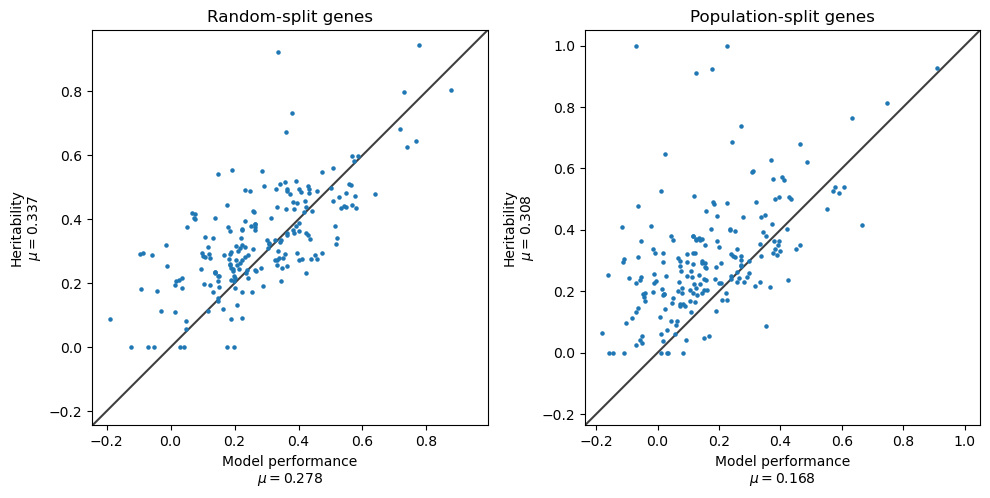

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
heritability_per_gene = load_heritability_per_gene("heritability.all_samples.tsv")
model_perf_per_gene = load_model_perf_per_gene()
compare_model_perf_to_heritability(model_perf_per_gene, heritability_per_gene, axs[0], genes=random_split_genes)
axs[0].set_title("Random-split genes")
compare_model_perf_to_heritability(model_perf_per_gene, heritability_per_gene, axs[1], genes=population_split_genes)
axs[1].set_title("Population-split genes")
plt.tight_layout()
plt.show()

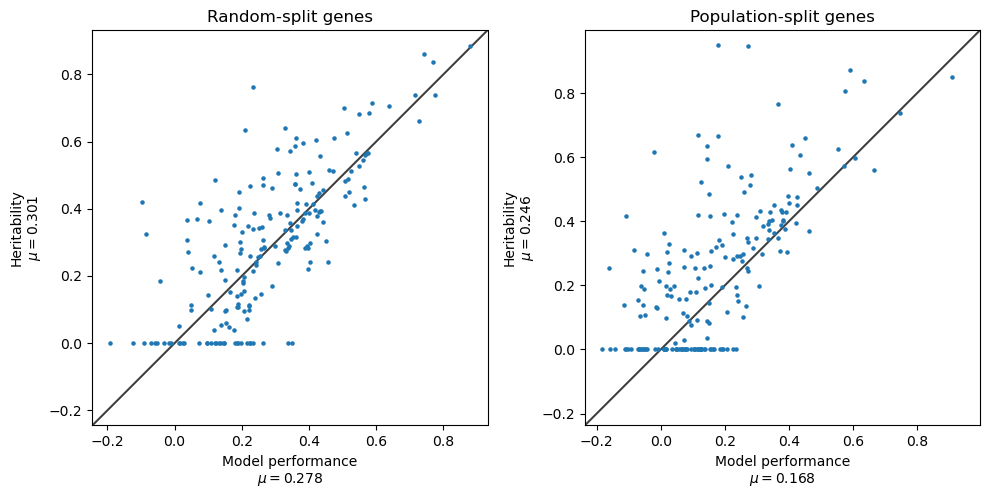

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
heritability_per_gene = load_heritability_per_gene("heritability.test_samples.tsv")
model_perf_per_gene = load_model_perf_per_gene()
compare_model_perf_to_heritability(model_perf_per_gene, heritability_per_gene, axs[0], genes=random_split_genes)
axs[0].set_title("Random-split genes")
compare_model_perf_to_heritability(model_perf_per_gene, heritability_per_gene, axs[1], genes=population_split_genes)
axs[1].set_title("Population-split genes")
plt.tight_layout()
plt.show()

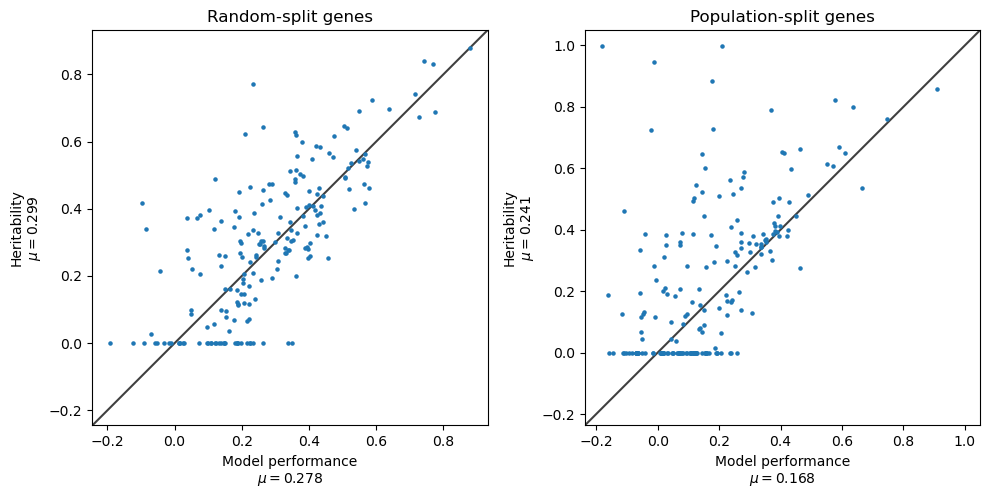

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
heritability_per_gene = load_heritability_per_gene("heritability.test_samples_with_train_variants.tsv")
model_perf_per_gene = load_model_perf_per_gene()
compare_model_perf_to_heritability(model_perf_per_gene, heritability_per_gene, axs[0], genes=random_split_genes)
axs[0].set_title("Random-split genes")
compare_model_perf_to_heritability(model_perf_per_gene, heritability_per_gene, axs[1], genes=population_split_genes)
axs[1].set_title("Population-split genes")
plt.tight_layout()
plt.show()

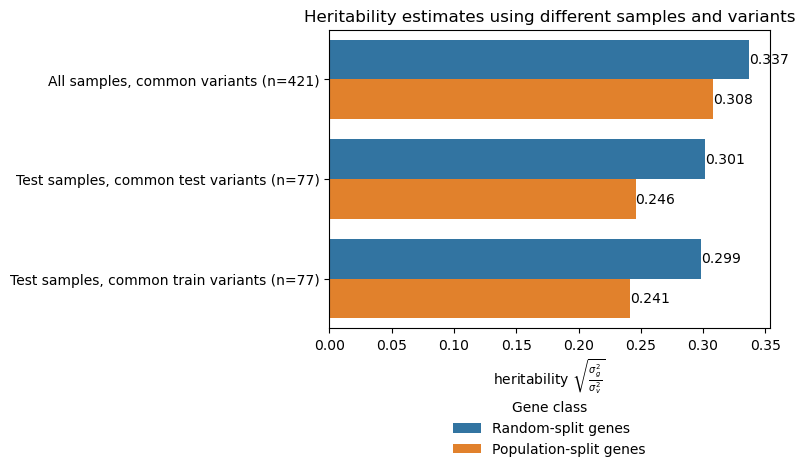

In [56]:
HERITABILITY_PATHS_PER_SETTING = {
    "All samples, common variants (n=421)": "heritability.all_samples.tsv",
    "Test samples, common test variants (n=77)": "heritability.test_samples.tsv",
    "Test samples, common train variants (n=77)": "heritability.test_samples_with_train_variants.tsv",
}

settings = []
splits = []
heritabilities = []
for setting, heritability_path in HERITABILITY_PATHS_PER_SETTING.items():
    heritability_per_gene = load_heritability_per_gene(heritability_path)

    # Random-split
    random_split_h = [heritability_per_gene[g] for g in random_split_genes]
    settings.append(setting)
    splits.append("Random-split genes")
    heritabilities.append(np.mean(random_split_h))

    # Population-split
    population_split_h = [heritability_per_gene[g] for g in population_split_genes]
    settings.append(setting)
    splits.append("Population-split genes")
    heritabilities.append(np.mean(population_split_h))

heritability_df = pd.DataFrame({
    "setting": settings,
    "split": splits,
    "heritability": heritabilities,
})

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=heritability_df, x="heritability", y="setting", hue="split", ax=ax)
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge")

ax.set_xlabel("heritability " + r"$\sqrt{\frac{\sigma^{2}_g}{\sigma^{2}_v}}$")
ax.set_ylabel("")
ax.set_title("Heritability estimates using different samples and variants")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), title="Gene class", frameon=False)
plt.tight_layout()
plt.show()